### ssGSEA analysis on data from TCGA-BRCA dataset
* This can be used as a template and adjusted for different TCGA datasets and signatures

In [49]:
library(matrixStats)
library(circlize)
library(ComplexHeatmap)
library(data.table)
library(SummarizedExperiment)
library(S4Vectors)
library(GenomicRanges)
library(IRanges)
library(dplyr)


Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
#set working directory (location where TCGA data is stored)
setwd("/scratch/user/s4436039/TCGA_Data")

In [9]:
#define SSGSEA Function
#function from https://rpubs.com/pranali018/SSGSEA  

ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
  row_names = rownames(X)
  num_genes = nrow(X)
  gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})
  
  # Ranks for genes
  R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')
  
  # Calculate enrichment score (es) for each sample (column)
  es = apply(R, 2, function(R_col) {
    gene_ranks = order(R_col, decreasing = TRUE)
    
    # Calc es for each gene set
    es_sample = sapply(gene_sets, function(gene_set_idx) {
      # pos: match (within the gene set)
      # neg: non-match (outside the gene set)
      indicator_pos = gene_ranks %in% gene_set_idx
      indicator_neg = !indicator_pos
      
      rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha
      
      step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
      step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)
      
      step_cdf_diff = step_cdf_pos - step_cdf_neg
      
      # Normalize by gene number
      if (scale) step_cdf_diff = step_cdf_diff / num_genes
      
      # Use ssGSEA or not
      if (single) {
        sum(step_cdf_diff)
      } else {
        step_cdf_diff[which.max(abs(step_cdf_diff))]
      }
    })
    unlist(es_sample)
  })
  
  if (length(gene_sets) == 1) es = matrix(es, nrow = 1)
  
  # Normalize by absolute diff between max and min
  if (norm) es = es / diff(range(es))
  
  # Prepare output
  rownames(es) = names(gene_sets)
  colnames(es) = colnames(X)
  return(es)
}


In [27]:
# load in TCGA_BRCA data 
## data was previously downloaded using the TCGAbiolinks package in R and saved as an RDS object 
TCGA_BRCA <- readRDS("TCGA_BRCA.rds")
TCGA_BRCA
summary(TCGA_BRCA)
colnames(colData(TCGA_BRCA))

class: RangedSummarizedExperiment 
dim: 60660 1231 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(10): source type ... hgnc_id havana_gene
colnames(1231): TCGA-E9-A1RH-01A-21R-A169-07
  TCGA-C8-A26W-01A-11R-A16F-07 ... TCGA-HN-A2OB-01A-21R-A27Q-07
  TCGA-A8-A09M-01A-11R-A00Z-07
colData names(88): barcode patient ... paper_PARADIGM Clusters
  paper_Pan-Gyn Clusters

[1] "RangedSummarizedExperiment object of length 60660 with 10 metadata columns"

[1] "barcode"                                  
 [2] "patient"                                  
 [3] "sample"                                   
 [4] "shortLetterCode"                          
 [5] "definition"                               
 [6] "sample_submitter_id"                      
 [7] "sample_type_id"                           
 [8] "tumor_descriptor"                         
 [9] "sample_id"                                
[10] "sample_type"                              
[11] "composition"                              
[12] "days_to_collection"                       
[13] "state"                                    
[14] "initial_weight"                           
[15] "preservation_method"                      
[16] "pathology_report_uuid"                    
[17] "submitter_id"                             
[18] "oct_embedded"                             
[19] "specimen_type"                            
[20] "is_ffpe"                                  
[21] "tissue_type"                              
[22] "synchronous_malignancy"                   
[23] "ajcc_pathologic_stage"                    
[24] "days_to_diagnosis"                        
[25] "treatments"                               
[26] "last_known_disease_status"                
[27] "tissue_or_organ_of_origin"                
[28] "days_to_last_follow_up"                   
[29] "age_at_diagnosis"                         
[30] "primary_diagnosis"                        
[31] "prior_malignancy"                         
[32] "year_of_diagnosis"                        
[33] "prior_treatment"                          
[34] "ajcc_staging_system_edition"              
[35] "ajcc_pathologic_t"                        
[36] "morphology"                               
[37] "ajcc_pathologic_n"                        
[38] "ajcc_pathologic_m"                        
[39] "classification_of_tumor"                  
[40] "diagnosis_id"                             
[41] "icd_10_code"                              
[42] "site_of_resection_or_biopsy"              
[43] "tumor_grade"                              
[44] "progression_or_recurrence"                
[45] "alcohol_history"                          
[46] "exposure_id"                              
[47] "race"                                     
[48] "gender"                                   
[49] "ethnicity"                                
[50] "vital_status"                             
[51] "age_at_index"                             
[52] "days_to_birth"                            
[53] "year_of_birth"                            
[54] "demographic_id"                           
[55] "bcr_patient_barcode"                      
[56] "primary_site"                             
[57] "project_id"                               
[58] "disease_type"                             
[59] "name"                                     
[60] "releasable"                               
[61] "released"                                 
[62] "days_to_death"                            
[63] "year_of_death"                            
[64] "days_to_sample_procurement"               
[65] "paper_patient"                            
[66] "paper_Tumor.Type"                         
[67] "paper_Included_in_previous_marker_papers" 
[68] "paper_vital_status"                       
[69] "paper_days_to_birth"                      
[70] "paper_days_to_death"                      
[71] "paper_days_to_last_followup"              
[72] "paper_age_at_initial_pathologic_diagnosis"
[73] "paper_pathologic_stage"                   
[74] "paper_Tumor_Grade"                        
[75] "paper_BRCA_Pathology"                     
[76] "paper_BRCA_Subtype_PAM50"                 
[77] "paper_MSI_status"                         
[78] "paper_HPV_Status"                         
[79] "paper_tobacco_smoking_history"            
[80] "paper_CNV Clusters"                       
[81] "paper_Mutation Clusters"                  
[82] "paper_DNA.Methylation Clus

In [14]:
#view the different assays stored
assays(TCGA_BRCA)

List of length 6
names(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand

In [28]:
#for this analysis using the tpm_unstrand assay 
dim(assays(TCGA_BRCA)$tpm_unstrand)
#set data to tpm_unstand assay for this analysis
data <- assays(TCGA_BRCA)$tpm_unstrand
#view data
data[1:3,1:3]

[1] 60660  1231

,TCGA-E9-A1RH-01A-21R-A169-07,TCGA-C8-A26W-01A-11R-A16F-07,TCGA-E9-A1RH-11A-34R-A169-07
ENSG00000000003.15,3.6813,44.5418,34.0830
ENSG00000000005.6,0.0000,0.4196,22.5726
ENSG00000000419.13,266.0582,127.3297,57.6085


In [29]:
#convert to matrix
data = as.matrix(data)

In [30]:
#load in my signature and make it a list (edit this to any signature)
sig <- fread("ag_pos_vs_dll1_deg_limma.csv", select = c("gene_id"))
sig <- sig[1:100,]
sig = as.list(as.data.frame(sig))
head(sig)

$gene_id
  [1] "ENSG00000102962.5"  "ENSG00000104951.16" "ENSG00000198053.12"
  [4] "ENSG00000126353.3"  "ENSG00000171310.11" "ENSG00000180758.12"
  [7] "ENSG00000090104.12" "ENSG00000023445.16" "ENSG00000056558.11"
 [10] "ENSG00000198223.17" "ENSG00000107021.16" "ENSG00000078081.8" 
 [13] "ENSG00000118242.16" "ENSG00000167641.11" "ENSG00000198369.10"
 [16] "ENSG00000112149.10" "ENSG00000136810.13" "ENSG00000172081.14"
 [19] "ENSG00000109320.13" "ENSG00000136111.14" "ENSG00000123374.11"
 [22] "ENSG00000261040.7"  "ENSG00000047365.12" "ENSG00000160445.11"
 [25] "ENSG00000151726.15" "ENSG00000167642.13" "ENSG00000161011.20"
 [28] "ENSG00000204634.13" "ENSG00000101384.12" "ENSG00000278834.1" 
 [31] "ENSG00000156127.8"  "ENSG00000117036.12" "ENSG00000171791.14"
 [34] "ENSG00000068796.19" "ENSG00000075618.18" "ENSG00000118503.15"
 [37] "ENSG00000160050.15" "ENSG00000119508.18" "ENSG00000115165.10"
 [40] "ENSG00000115956.10" "ENSG00000150907.10" "ENSG00000025772.8" 
 [43] "ENSG00000135148.12" "ENSG00000101445.10" "ENSG00000121966.7" 
 [46] "ENSG00000101017.14" "ENSG00000198018.7"  "ENSG00000124762.14"
 [49] "ENSG00000015475.19" "ENSG00000277443.3"  "ENSG00000138166.6" 
 [52] "ENSG00000071054.16" "ENSG00000171552.14" "ENSG00000172183.15"
 [55] "ENSG00000145860.12" "ENSG00000137522.18" "ENSG00000183484.12"
 [58] "ENSG00000138670.18" "ENSG00000197872.11" "ENSG00000084733.11"
 [61] "ENSG00000172292.15" "ENSG00000115594.12" "ENSG00000101109.12"
 [64] "ENSG00000069493.15" "ENSG00000217801.10" "ENSG00000177311.11"
 [67] "ENSG00000159128.15" "ENSG00000120217.14" "ENSG00000136052.9" 
 [70] "ENSG00000118257.17" "ENSG00000164236.12" "ENSG00000169508.7" 
 [73] "ENSG00000163389.12" "ENSG00000128271.22" "ENSG00000102221.14"
 [76] "ENSG00000131773.14" "ENSG00000168036.18" "ENSG00000137571.11"
 [79] "ENSG00000077150.20" "ENSG00000116741.8"  "ENSG00000106803.10"
 [82] "ENSG00000186187.12" "ENSG00000104856.14" "ENSG00000151131.11"
 [85] "ENSG00000168310.11" "ENSG00000273604.2"  "ENSG00000059728.11"
 [88] "ENSG00000111540.16" "ENSG00000117115.13" "ENSG00000136048.14"
 [91] "ENSG00000108389.9"  "ENSG00000103319.12" "ENSG00000111846.19"
 [94] "ENSG00000173166.18" "ENSG00000140379.9"  "ENSG00000101310.17"
 [97] "ENSG00000198355.5"  "ENSG00000163297.17" "ENSG00000166016.6" 
[100] "ENSG00000164484.12"

In [37]:
#Run ssGSEA function
#ssgsea: https://rpubs.com/pranali018/SSGSEA
system.time(assign('res', ssgsea(data, sig, scale = TRUE, norm = FALSE)))

   user  system elapsed 
 11.551   1.172  12.793 

In [38]:
#transpose results
res1 = t(res)
head(res1)

,gene_id
TCGA-E9-A1RH-01A-21R-A169-07,0.3818250
TCGA-C8-A26W-01A-11R-A16F-07,0.3827926
TCGA-E9-A1RH-11A-34R-A169-07,0.3669738
TCGA-AO-A0JJ-01A-11R-A056-07,0.3885975
TCGA-BH-A0HO-01A-11R-A034-07,0.3812644
TCGA-BH-A18F-01A-11R-A12D-07,0.3929040


In [39]:
#calculate mat (ssGSEA Z score - ssgsea output for comparative analysis)
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]
dim(mat)
mat[1,1:5] 

[1]    1 1231

TCGA-E9-A1RH-01A-21R-A169-07 TCGA-C8-A26W-01A-11R-A16F-07 
                  0.13165243                   0.20014851 
TCGA-E9-A1RH-11A-34R-A169-07 TCGA-AO-A0JJ-01A-11R-A056-07 
                 -0.91959370                   0.61105078 
TCGA-BH-A0HO-01A-11R-A034-07 
                  0.09197547

#### at this point now have a score for each patient with how enriched that sample is for my signature, the ID here is the "barcode"
* next want to see how this score correlates with survival etc

In [40]:
#to view the types of data stored for each sample 
colnames(colData(TCGA_BRCA))

[1] "barcode"                                  
 [2] "patient"                                  
 [3] "sample"                                   
 [4] "shortLetterCode"                          
 [5] "definition"                               
 [6] "sample_submitter_id"                      
 [7] "sample_type_id"                           
 [8] "tumor_descriptor"                         
 [9] "sample_id"                                
[10] "sample_type"                              
[11] "composition"                              
[12] "days_to_collection"                       
[13] "state"                                    
[14] "initial_weight"                           
[15] "preservation_method"                      
[16] "pathology_report_uuid"                    
[17] "submitter_id"                             
[18] "oct_embedded"                             
[19] "specimen_type"                            
[20] "is_ffpe"                                  
[21] "tissue_type"                              
[22] "synchronous_malignancy"                   
[23] "ajcc_pathologic_stage"                    
[24] "days_to_diagnosis"                        
[25] "treatments"                               
[26] "last_known_disease_status"                
[27] "tissue_or_organ_of_origin"                
[28] "days_to_last_follow_up"                   
[29] "age_at_diagnosis"                         
[30] "primary_diagnosis"                        
[31] "prior_malignancy"                         
[32] "year_of_diagnosis"                        
[33] "prior_treatment"                          
[34] "ajcc_staging_system_edition"              
[35] "ajcc_pathologic_t"                        
[36] "morphology"                               
[37] "ajcc_pathologic_n"                        
[38] "ajcc_pathologic_m"                        
[39] "classification_of_tumor"                  
[40] "diagnosis_id"                             
[41] "icd_10_code"                              
[42] "site_of_resection_or_biopsy"              
[43] "tumor_grade"                              
[44] "progression_or_recurrence"                
[45] "alcohol_history"                          
[46] "exposure_id"                              
[47] "race"                                     
[48] "gender"                                   
[49] "ethnicity"                                
[50] "vital_status"                             
[51] "age_at_index"                             
[52] "days_to_birth"                            
[53] "year_of_birth"                            
[54] "demographic_id"                           
[55] "bcr_patient_barcode"                      
[56] "primary_site"                             
[57] "project_id"                               
[58] "disease_type"                             
[59] "name"                                     
[60] "releasable"                               
[61] "released"                                 
[62] "days_to_death"                            
[63] "year_of_death"                            
[64] "days_to_sample_procurement"               
[65] "paper_patient"                            
[66] "paper_Tumor.Type"                         
[67] "paper_Included_in_previous_marker_papers" 
[68] "paper_vital_status"                       
[69] "paper_days_to_birth"                      
[70] "paper_days_to_death"                      
[71] "paper_days_to_last_followup"              
[72] "paper_age_at_initial_pathologic_diagnosis"
[73] "paper_pathologic_stage"                   
[74] "paper_Tumor_Grade"                        
[75] "paper_BRCA_Pathology"                     
[76] "paper_BRCA_Subtype_PAM50"                 
[77] "paper_MSI_status"                         
[78] "paper_HPV_Status"                         
[79] "paper_tobacco_smoking_history"            
[80] "paper_CNV Clusters"                       
[81] "paper_Mutation Clusters"                  
[82] "paper_DNA.Methylation Clus

In [41]:
#change column name
mat <- t(mat)
dim(mat)
colnames(mat) <- c("mat")
head(mat)

[1] 1231    1

,mat
TCGA-E9-A1RH-01A-21R-A169-07,0.13165243
TCGA-C8-A26W-01A-11R-A16F-07,0.20014851
TCGA-E9-A1RH-11A-34R-A169-07,-0.91959370
TCGA-AO-A0JJ-01A-11R-A056-07,0.61105078
TCGA-BH-A0HO-01A-11R-A034-07,0.09197547
TCGA-BH-A18F-01A-11R-A12D-07,0.91588389


In [42]:
#now look at days to death, plot K-M curved grouped by groups of mat score 
###following this tutorial: https://www.youtube.com/watch?v=DnygUTAZFmM

#making a matrix with all the data I need
death_days <- colData(TCGA_BRCA)$days_to_death
names(death_days) <- row.names(colData(TCGA_BRCA))
followup_days <- colData(TCGA_BRCA)$days_to_last_follow_up
names(followup_days) <- row.names(colData(TCGA_BRCA))
status <- colData(TCGA_BRCA)$vital_status
names(status) <- row.names(colData(TCGA_BRCA))

concat_survival <- cbind(mat,followup_days,status,death_days)
colnames(concat_survival) <- c("mat","Days_to_last_follow_up","vital_status","days_to_death")
head(concat_survival) 
concat_survival <- as.data.frame(concat_survival)
#now I have a table with the above variables for each patient

,mat,Days_to_last_follow_up,vital_status,days_to_death
TCGA-E9-A1RH-01A-21R-A169-07,0.131652432134769,1417,Alive,NA
TCGA-C8-A26W-01A-11R-A16F-07,0.20014850522894,381,Alive,NA
TCGA-E9-A1RH-11A-34R-A169-07,-0.919593702888573,1417,Alive,NA
TCGA-AO-A0JJ-01A-11R-A056-07,0.611050779844261,1887,Alive,NA
TCGA-BH-A0HO-01A-11R-A034-07,0.0919754749212825,76,Alive,NA
TCGA-BH-A18F-01A-11R-A12D-07,0.915883889810977,1001,Alive,NA


In [43]:
#make a new column that records whether or not deceased, this will be needed for status in survival anakysis (for censoring)
concat_survival$deceased <- ifelse(concat_survival$vital_status == "Alive", FALSE, TRUE)
head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased
,<chr>,<chr>,<chr>,<chr>,<lgl>
TCGA-E9-A1RH-01A-21R-A169-07,0.131652432134769,1417,Alive,NA,FALSE
TCGA-C8-A26W-01A-11R-A16F-07,0.20014850522894,381,Alive,NA,FALSE
TCGA-E9-A1RH-11A-34R-A169-07,-0.919593702888573,1417,Alive,NA,FALSE
TCGA-AO-A0JJ-01A-11R-A056-07,0.611050779844261,1887,Alive,NA,FALSE
TCGA-BH-A0HO-01A-11R-A034-07,0.0919754749212825,76,Alive,NA,FALSE
TCGA-BH-A18F-01A-11R-A12D-07,0.915883889810977,1001,Alive,NA,FALSE


In [44]:
#next need to make a "overall survival" column that is equal to days to death for dead patients and to days to last follow up for patients who are still alive 
concat_survival$overall_survival <- ifelse(concat_survival$vital_status == "Alive",
                                           concat_survival$Days_to_last_follow_up,
                                           concat_survival$days_to_death)

#convert overall_survival to numeric
concat_survival$overall_survival <- as.numeric(concat_survival$overall_survival)

head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
TCGA-E9-A1RH-01A-21R-A169-07,0.131652432134769,1417,Alive,NA,FALSE,1417
TCGA-C8-A26W-01A-11R-A16F-07,0.20014850522894,381,Alive,NA,FALSE,381
TCGA-E9-A1RH-11A-34R-A169-07,-0.919593702888573,1417,Alive,NA,FALSE,1417
TCGA-AO-A0JJ-01A-11R-A056-07,0.611050779844261,1887,Alive,NA,FALSE,1887
TCGA-BH-A0HO-01A-11R-A034-07,0.0919754749212825,76,Alive,NA,FALSE,76
TCGA-BH-A18F-01A-11R-A12D-07,0.915883889810977,1001,Alive,NA,FALSE,1001


In [47]:
# load packages needed for survival analysis
library(survival)
library(survminer)

Loading required package: ggplot2



Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [ ]:
#fitting survival curve - prepare data: 

# for my analysis I wanted to plot top vs bottom third on my KM plot, but could also split 50/50 if you wanted
# make variable for either top 33% or bottom 33% mat score
#calculate 66th percentile (above this is top 33%) and 33rd percentile (below this is bottom 33%)
perc_66 <- quantile(mat, probs = c(0.66))
perc_33 <- quantile(mat, probs = c(0.33))

concat_survival_Full <- concat_survival
concat_survival_Full$strata <- ifelse(concat_survival_Full$mat < perc_33, "Bottom 33%",
                                  ifelse(concat_survival_Full$mat >perc_66, "Top 33%", "Middle"))

head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-E9-A1RH-01A-21R-A169-07,0.131652432134769,1417,Alive,NA,FALSE,1417,Middle
TCGA-C8-A26W-01A-11R-A16F-07,0.20014850522894,381,Alive,NA,FALSE,381,Middle
TCGA-E9-A1RH-11A-34R-A169-07,-0.919593702888573,1417,Alive,NA,FALSE,1417,Middle
TCGA-AO-A0JJ-01A-11R-A056-07,0.611050779844261,1887,Alive,NA,FALSE,1887,Top 33%
TCGA-BH-A0HO-01A-11R-A034-07,0.0919754749212825,76,Alive,NA,FALSE,76,Middle
TCGA-BH-A18F-01A-11R-A12D-07,0.915883889810977,1001,Alive,NA,FALSE,1001,Top 33%


In [50]:
#need to remove middle strata from plot
concat_survival_Full <- concat_survival_Full %>% filter(strata %in% c("Top 33%", "Bottom 33%"))
head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-AO-A0JJ-01A-11R-A056-07,0.611050779844261,1887,Alive,NA,FALSE,1887,Top 33%
TCGA-BH-A18F-01A-11R-A12D-07,0.915883889810977,1001,Alive,NA,FALSE,1001,Top 33%
TCGA-C8-A12O-01A-11R-A115-07,0.484746110604676,385,Alive,NA,FALSE,385,Top 33%
TCGA-BH-A0HY-01A-11R-A056-07,-0.172734176109865,1545,Alive,NA,FALSE,1545,Bottom 33%
TCGA-BH-A42U-01A-12R-A24H-07,0.38953798921357,3364,Alive,NA,FALSE,3364,Top 33%
TCGA-S3-AA17-01A-11R-A41B-07,1.44021772454062,424,Alive,NA,FALSE,424,Top 33%


In [51]:
#Fit survival curve
fit <- survfit(Surv(overall_survival, deceased) ~ strata, data = concat_survival_Full)
fit

Call: survfit(formula = Surv(overall_survival, deceased) ~ strata, 
    data = concat_survival_Full)

   1 observation deleted due to missingness 
                    n events median 0.95LCL 0.95UCL
strata=Bottom 33% 198     36   3926    2866      NA
strata=Top 33%    418     62   3669    3461      NA

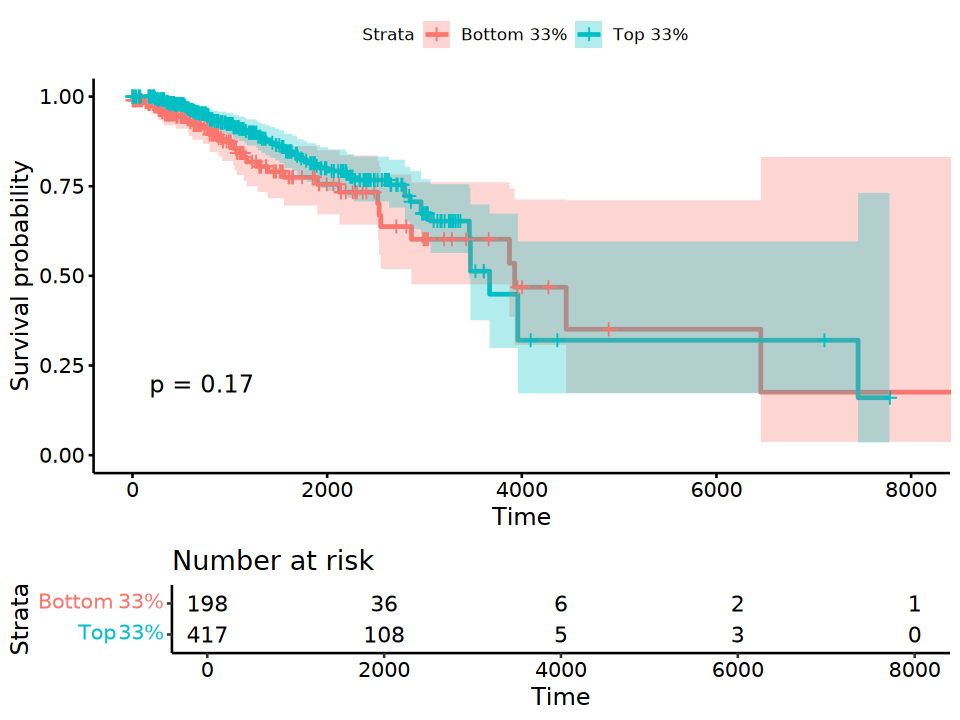

In [60]:
#generate survival plot
options(repr.plot.height=6, repr.plot.width=8)
ggsurvplot(fit,
           data = concat_survival_Full,
           pval = T,
           risk.table = T,
           conf.int = TRUE)